In [1]:
from blockchain import (Block,
                        Transaction,
                        BlockchainPeer,
                        BlockchainMainnet,
                        )
import matplotlib_inline as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import random
import logging

In [2]:
random.seed(42)

### Task 1. Form the following block and calculate its hash.

In [3]:
data = {
    'index': 4,
    'timestamp': 0,
    'previous_hash':'0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3',
    'nonce': 0,
    'author': 'Satoshi',
    'transactions': [
        {
            'sender_address': 'Alice',
            'recipient_address': 'Bob',
            'value': 10,
            'data': 'Hello Bob!',
        },
        {
            'sender_address': 'Bob',
            'recipient_address': 'Alice',
            'value': 5,
            'data': 'Hello Alice!',
        }
    ]
}

In [4]:
transactions = [Transaction(**tx) for tx in data['transactions']]

In [5]:
block = Block(index=data['index'],
              transactions=transactions,
              author=data['author'],
              timestamp=data['timestamp'],
              previous_hash=data['previous_hash'],
              nonce=data['nonce'])

In [6]:
block_hash = block.compute_hash()
block_hash

'e02f8bf9303b7b42b77e313887564761dd4923104a9a4d399161adf945b6f064'

### Task 2. Run PoW algorithm and find the proof of this block (from task1) with difficulty=3.

In [7]:
BlockchainPeer.difficulty = 3

In [8]:
BlockchainPeer.proof_of_work(block)

'0002e55332ede6e065fdc770f1ba8c026dbfa86b076a4369cf3aa49913629e21'

In [9]:
block.nonce

1021

### Task 3.  Init a single peer and mine 2 blocks with the same 2 transactions from the task1. Why hashes for these blocks are not the same?

In [10]:
peer = BlockchainPeer(peer_name='first_peer')

In [11]:
peer.add_new_transaction(transaction=transactions[0])
peer.add_new_transaction(transaction=transactions[1])
peer.mine()

In [12]:
peer.add_new_transaction(transaction=transactions[0])
peer.add_new_transaction(transaction=transactions[1])
peer.mine()

In [13]:
peer.chain

[{'index': 0, 'author': 'Satoshi', 'transactions': '[]', 'timestamp': 0, 'previous_hash': '0', 'nonce': 2529, 'hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658'},
 {'index': 1, 'author': 'first_peer', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}, {"data": "Hello Alice!", "recipient_address": "Alice", "sender_address": "Bob", "tx_hash": "27ef2609d6803837823486454e7cb83005bfc8483a1dfdbf6f3651343d00b40c", "value": 5}]', 'timestamp': 1740942974.4771578, 'previous_hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658', 'nonce': 2123, 'hash': '0008414bc173c5ea583d9bc82820a6d0720d24c498e3dad5a4129cbab7a7e112'},
 {'index': 2, 'author': 'first_peer', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec

Хеши блоков различны, так как блоки имеют разные значения `timestamp`, `previous_hash`, `nonce`

In [14]:
block_1 = peer.chain[1]
block_2 = peer.chain[2]

In [15]:
proof1 = BlockchainPeer.proof_of_work(block_1)
proof2 = BlockchainPeer.proof_of_work(block_2)

print("Hash of block_1:", block_1.compute_hash())
print("Hash of block_2:", block_2.compute_hash())

Hash of block_1: 00098547a4b0b7d19f7ffaa45f44e06ee17219e4de6cb8e566b7be941d88d00c
Hash of block_2: 00092863b9d99018b2ca1d508568c92ffc7c31a40aeb0d45647b3b46312e76b5


Хеш блоков с одинаковыми транзакциями различается, так как они имеют различные значения `nonce` и `timestamp`

### Task 4. Mine 100 blocks (in 1 block should be max 5 transactions) with 5 peers. Plot a distribution of mined blocks by each peer. Explain why the distributions look like this? Now turn on a difficulty bomb and make the same

In [16]:
peers = [BlockchainPeer(f'Peer_{i}') for i in range(5)]
mainnet = BlockchainMainnet(peers)

In [17]:
names = ("Alice", "Bob", "Charlie", "Dave", "Eve")

In [18]:
for _ in trange(100):
    num_of_transactions = random.randint(1, 5)
    for _ in range(num_of_transactions):
        sender_addrress, recipient_address = random.choices(names, k=2)
        transaction = Transaction(sender_address=sender_addrress,
                                    recipient_address=recipient_address,
                                    value=random.randint(1, 10),
                                    data=f"Hello, {recipient_address}!")
        for peer in peers:
            peer.add_new_transaction(transaction=transaction)

    mainnet.run_mining()

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
def count_blocks_per_peer(mainnet: BlockchainMainnet) -> dict:
    chain = mainnet.get_chain()['chain']
    blocks_per_peer = {}
    for block in chain:
        blocks_per_peer[block.author] = blocks_per_peer.get(block.author, 0) + 1
    return blocks_per_peer

In [20]:
blocks_per_peer = count_blocks_per_peer(mainnet)
blocks_per_peer

{'Satoshi': 1,
 'Peer_3': 18,
 'Peer_4': 25,
 'Peer_1': 20,
 'Peer_0': 19,
 'Peer_2': 18}

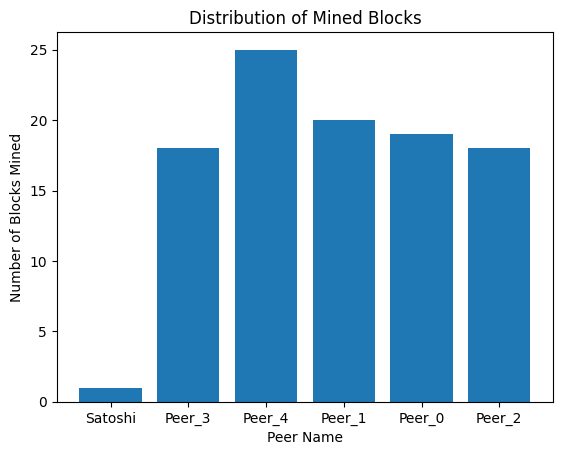

In [21]:
plt.bar(blocks_per_peer.keys(), blocks_per_peer.values())
plt.xlabel('Peer Name')
plt.ylabel('Number of Blocks Mined')
plt.title('Distribution of Mined Blocks')
plt.show()

Поставим `difficulty_bomb=True` при майнинге

In [22]:
peers_with_bomb = [BlockchainPeer(f'Peer_with_bomb_{i}') for i in range(5)]
mainnet_with_bomb = BlockchainMainnet(peers_with_bomb)

In [23]:
for _ in trange(100):
    num_of_transactions = random.randint(1, 5)
    for _ in range(num_of_transactions):
        sender_addrress, recipient_address = random.choices(names, k=2)
        transaction = Transaction(sender_address=sender_addrress,
                                  recipient_address=recipient_address,
                                  value=random.randint(1, 10),
                                  data=f"Hello, {recipient_address}!")
        for peer in peers_with_bomb:
            peer.add_new_transaction(transaction=transaction)

    mainnet_with_bomb.run_mining(difficulty_bomb=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
blocks_per_peer_with_bomb = count_blocks_per_peer(mainnet_with_bomb)
blocks_per_peer_with_bomb

{'Satoshi': 1,
 'Peer_with_bomb_2': 23,
 'Peer_with_bomb_4': 21,
 'Peer_with_bomb_0': 17,
 'Peer_with_bomb_1': 22,
 'Peer_with_bomb_3': 17}

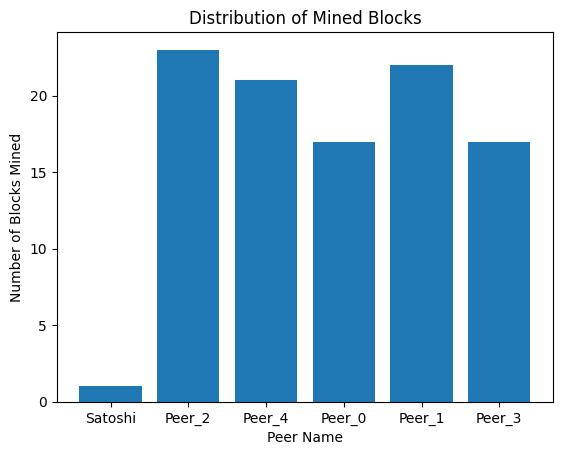

In [37]:
plt.bar([peer_name.replace("_with_bomb", "") for peer_name in list(blocks_per_peer_with_bomb.keys())],
        blocks_per_peer_with_bomb.values())
plt.xlabel('Peer Name')
plt.ylabel('Number of Blocks Mined')
plt.title('Distribution of Mined Blocks')
plt.show()

Какого-то очевидного различия между распределениями транзакций по пирам при наличии и отсутствии `difficulty_bomb` не наблюдается.

### Task5. Suppose all blocks have the same timestamp as the genesis block. Mine 5 blocks with transactions from task1 - use the peer name 'Satoshi'. Use the template below to override the updated mine() function with fixed timestamp.

### Find the hash of the block after the block from the task2.

In [26]:
class FixedTimeBlockchainPeer(BlockchainPeer):

    def mine(self, difficulty_bomb: bool = False):
        """
        This function serves as an interface to add the pending
        transactions to the blockchain by adding them to the block
        and figuring out Proof Of Work.
        """
        logging.info(f"{self.peer_name} | Start mining")

        if not self.unconfirmed_transactions:
            logging.info(f"{self.peer_name} | No transactions to mine")
            return

        last_block: Block = self.last_block
        new_block = Block(
            index=last_block.index + 1,
            transactions=self.unconfirmed_transactions,
            author=self.peer_name,
            timestamp=0, # Fixed timestamp
            previous_hash=last_block.hash,
            nonce=0,
        )
        proof = self.proof_of_work(new_block, difficulty_bomb)
        logging.info(f"{self.peer_name} | Found proof {proof}")
        self._add_block(new_block, proof)
        self.unconfirmed_transactions = []
        self._announce()

In [27]:
satoshi_peer = FixedTimeBlockchainPeer('Satoshi')

In [28]:
for _ in trange(5):
    satoshi_peer.add_new_transaction(transaction=transactions[0])
    satoshi_peer.add_new_transaction(transaction=transactions[1])

    satoshi_peer.mine()

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
satoshi_peer.chain

[{'index': 0, 'author': 'Satoshi', 'transactions': '[]', 'timestamp': 0, 'previous_hash': '0', 'nonce': 2529, 'hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658'},
 {'index': 1, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}, {"data": "Hello Alice!", "recipient_address": "Alice", "sender_address": "Bob", "tx_hash": "27ef2609d6803837823486454e7cb83005bfc8483a1dfdbf6f3651343d00b40c", "value": 5}]', 'timestamp': 0, 'previous_hash': '000d66472480c5116303eaced5338aee2605ed6104d0787ce7cf23b99fb29658', 'nonce': 9199, 'hash': '0001388e4938037f9c8ef8742d8debbc4200fd9309dbae57e3b081966cbeff65'},
 {'index': 2, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}

In [ ]:
satoshi_peer.chain[5]

{'index': 5, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}, {"data": "Hello Alice!", "recipient_address": "Alice", "sender_address": "Bob", "tx_hash": "27ef2609d6803837823486454e7cb83005bfc8483a1dfdbf6f3651343d00b40c", "value": 5}]', 'timestamp': 0, 'previous_hash': '0002e55332ede6e065fdc770f1ba8c026dbfa86b076a4369cf3aa49913629e21', 'nonce': 10980, 'hash': '0000b74269d01b5160e499123ffa0e78e0d24ab0b9145cb06fcb4188cc43bdd9'}

In [31]:
block

{'index': 4, 'author': 'Satoshi', 'transactions': '[{"data": "Hello Bob!", "recipient_address": "Bob", "sender_address": "Alice", "tx_hash": "e300df2f71abb04af98edee0f591aa91406d205bf7f200280e6982ec72b10a32", "value": 10}, {"data": "Hello Alice!", "recipient_address": "Alice", "sender_address": "Bob", "tx_hash": "27ef2609d6803837823486454e7cb83005bfc8483a1dfdbf6f3651343d00b40c", "value": 5}]', 'timestamp': 0, 'previous_hash': '0009e52e043a9f83524d01485dda65fe16b6d0dd4239c1c938834be249a432e3', 'nonce': 1021}